## **Pillars Of Creation**

*Through this notebook you are not just seeing **The Pillars Of creation** in the eagle nebula in the M31 cluster, you are flying by a sleepless night that too before exam !! Kudos!*

### **Layout**

* Data ingestion (FITS loading)
* Normalization (done to tackle false values and skewness)
* Preprocessing (stretching, gamma correction)
* Color mapping (RGB stacking)
* Detail enhancement (sharpening, contrast)
* Final rendering (display and export)
    

#### **Data ingestion**

* astropy.io.fits - Used for Loading your grayscale data arrays and accessing metadata if needed
* numpy - FITS data is just arrays — NumPy gives you full control over math, scaling, stacking, and masking.
* matplotlib - Displaying grayscale and RGB composites, saving final images.
* astropy.visualization - Includes advanced stretching tools tailored for astronomical data.
* scipy.ndimage - Offers filters like Gaussian and median for noise reduction and smoothing. Star halo reduction and soft blending.
* skimage.restoration - Contains richardson_lucy, a deconvolution algorithm that simulates super-resolution
* skimage.exposure - Includes CLAHE (adaptive histogram equalization) for local contrast enhancement

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import PercentileInterval, AsinhStretch, ImageNormalize
from scipy.ndimage import gaussian_filter, median_filter
from skimage.restoration import richardson_lucy
from skimage import exposure

In [2]:
# 📂 Load FITS files

fits_oiii = fits.open(r"C:\Users\DEEPMALYA\OneDrive\Desktop\pip_Malya\Astronomy\Pillars Of Creation\zdata\502nmos.fits")[0].data.astype(np.float32)
fits_ha = fits.open(r"C:\Users\DEEPMALYA\OneDrive\Desktop\pip_Malya\Astronomy\Pillars Of Creation\zdata\656nmos.fits")[0].data.astype(np.float32)
fits_sii = fits.open(r"C:\Users\DEEPMALYA\OneDrive\Desktop\pip_Malya\Astronomy\Pillars Of Creation\zdata\673nmos.fits")[0].data.astype(np.float32)


**Conventional Pipeline**

* Crop/ Align
* Normalize
* Stretch
* Gamma/ Channel boost
* Stack into RGB
* Luminance layer
* Noise reduction
* Final Touches(Contrasty Enhancement, Color grading)

#### Understanding the Statistics of the data

In [3]:
from astropy.stats import sigma_clipped_stats

def describe(img,name,mask_zeros=True):
    data=img.copy()
    if (mask_zeros):
        data=data[data!=0] # remove mosaic blanks from the data, or extract only the parts from the image that's not mpty and has a certain pixel value
    mean,med,std=sigma_clipped_stats(data,sigma=3.0, maxiters=5)
    p=np.percentile(data,[0.1, 1, 5, 50, 95, 99, 99.9])
    print(f"{name}: mean={mean:.3f}, median={med:.3f}, std={std:.3f}")
    print(f"{name} percentiles: 0.1={p[0]:.3f}, 1={p[1]:.3f}, 5={p[2]:.3f}, "f"50={p[3]:.3f}, 95={p[4]:.3f}, 99={p[5]:.3f}, 99.9={p[6]:.3f}\n")

In [4]:
describe(fits_oiii, "OIII")

OIII: mean=8.268, median=8.314, std=3.462
OIII percentiles: 0.1=0.544, 1=1.644, 5=2.531, 50=8.346, 95=14.402, 99=18.372, 99.9=71.479



In [5]:
describe(fits_sii, "OIII")

OIII: mean=9.453, median=8.484, std=3.347
OIII percentiles: 0.1=2.057, 1=4.082, 5=5.455, 50=8.869, 95=23.060, 99=41.919, 99.9=185.730



In [6]:
describe(fits_ha, "OIII")

OIII: mean=100.629, median=100.368, std=33.788
OIII percentiles: 0.1=28.023, 1=34.276, 5=43.535, 50=100.973, 95=166.171, 99=235.981, 99.9=350.569



### **Statistical Inferences**

**The median tells us the “background level” where most pixels sit**. Example:

Dataset 1: median ≈ 8.3; Dataset 2: median ≈ 8.5; Dataset 3: median ≈ 100

**Inference**: Channel 3 is much brighter overall. Channels 1 and 2 are faint, clustered near ~8. 

👉 This tells us Hα (channel 3) is strong and will dominate unless we normalize.

---

**Std shows how spread out the values are (noise + signal).**
**Inference**: Channel 3 has much higher variation → stronger stars and nebulosity. 

👉 This means we need gentler stretching for channel 3, otherwise stars will blow out.

---

**Percentiles show where faint nebulosity ends and stars begin.**
Example:

Dataset 1: 99% ≈ 18, 99.9% ≈ 71; Dataset 2: 99% ≈ 42, 99.9% ≈ 186; Dataset 3: 99% ≈ 236, 99.9% ≈ 350

**Inference**:
Channels 1 & 2: faint nebulosity lives between ~2–10, stars spike above ~40–70.
Channel 3: nebulosity lives between ~40–100, stars spike above ~236.

👉 This tells us where to clip percentile ranges (e.g., 1–99%) to suppress extreme stars but keep nebulosity.

**Therefore:**

**Channels 1 & 2 (faint)**: Need aggressive stretch (asinh/log) to lift faint gas.

**Channel 3 (bright)**: Needs gentle stretch (sqrt/asinh with lower beta) to avoid oversaturation.

👉 Stretch choice is based on how faint vs bright the distribution is.

--------

**Set channel weights**
Why: To balance color contributions in RGB stacking.

Logic:

Hα is strongest → weight ≈ 1.0

OIII weaker → boost ≈ 1.3–1.5

SII weakest → boost ≈ 1.5–1.8

👉 This ensures the SHO palette looks balanced (reds and blues don’t vanish under green).

------

**Apply gamma correction**
Why: Enhances midtones and gradients.

Logic:

Apply gamma ≈ 1.1–1.2 to weaker channels (SII, OIII).

Keep Hα gamma ≈ 1.0 (already strong).

👉 This makes faint structures glow without flattening bright stars.

---

**Choose luminance**
Why: Adds crisp detail.

Logic: Hα has the strongest signal → use as luminance.

Apply CLAHE for local contrast, then Richardson-Lucy for sharpening.

👉 This simulates “super-resolution” by overlaying detail onto the RGB composite.

#### Analysing the Histogram of the data

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_hist(data,name,bins=500):
    data=data[data!=0] # Remove zeres from the data

    # Trimming to remove the outliers from the data by the z score method, ML eo porbi ei part ta. Ways of detecting and treating an outlier.
    low=data.mean()-3*(data.std())
    high=data.mean()+3*(data.std())
    clipped=data[(data>=low) & (data<=high)]

    # Histogram plot kor6i simple
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].hist(clipped.flatten(),bins=bins,color='orange')
    # image t ultimately 2D array chilo..toh flatten use kr6i that Flattens the 2D image into a 1D array of pixel values. 
    # Plots a histogram with 500 bins.Shows how many pixels fall into each intensity range.

    ax[0].set_title(f"{name} Histogram ")
    ax[0].set_xlabel("Pixel value")
    ax[0].set_ylabel("Count")

    # CDF -> Cumulative distribution Function → tells you “what fraction of pixels are below X.Helps you decide percentile cutoffs (e.g., 99% vs 99.9%) for stretching.
    vals = np.sort(clipped.flatten())
    cdf = np.linspace(0, 1, len(vals))
    ax[1].plot(vals, cdf, color='teal')
    ax[1].set_title(f"{name} Cumulative Distribution")
    ax[1].set_xlabel("Pixel value")
    ax[1].set_ylabel("Cumulative fraction")
    
    plt.show()


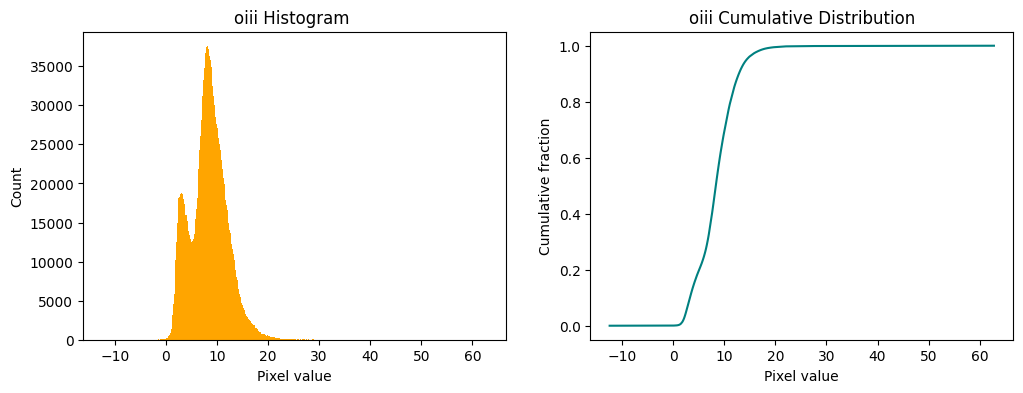

In [8]:
plot_hist(fits_oiii,'oiii')

### OIII Analysis
**Histogram**:
* Peak around 10, with a long tail reaching up to 60+.

* Most pixels are concentrated between 5–20.

**CDF**:
* Steep rise between 5–20, then flattens.

* ~99% of pixels are below 60.

**Inference**:
* Faint nebulosity lives around 5–20.

* Stars and bright regions push values above 40–60.

* Needs aggressive stretch to lift faint gas.

**Operations to perform**:

* Percentile cut: 1–99% → [~5, ~60]

* Stretch: asinh with beta ≈ 0.9

* Boost: Multiply by ~1.4, gamma ≈ 1.15

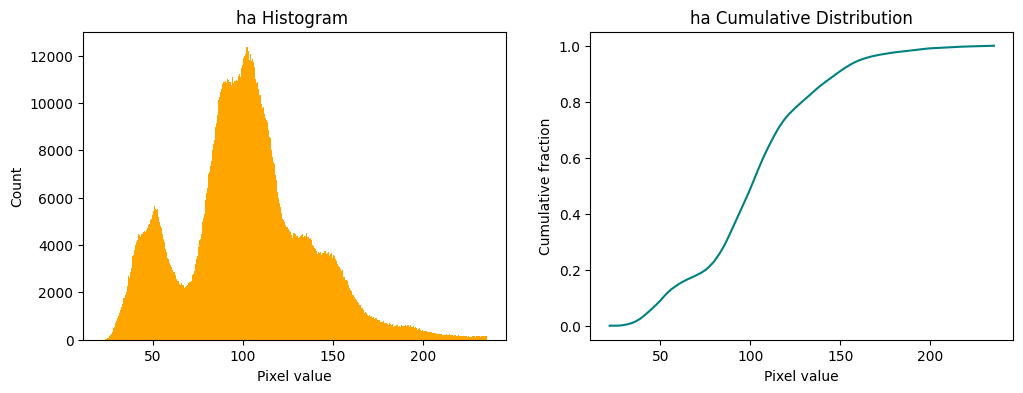

In [9]:
plot_hist(fits_ha,'ha')

### H-alpha Analysis
**Histogram**:
* Multiple peaks around 50, 100, 130.

* Wide spread from 0–255.

**CDF**:
* Smooth rise, indicating gradual accumulation.

* No sharp tail — signal is strong and evenly distributed.

**Inference**:
* This is the strongest channel.

* Nebulosity and stars are both well represented.

* Doesn’t need aggressive stretch — already rich.

**Operation**:
* Percentile cut: 1–99% → [~50, ~230]

* Stretch: sqrt or gentle asinh with beta ≈ 0.6

* Boost: gamma ≈ Keep at 1.0, 1.0

* Use as luminance layer for sharpening

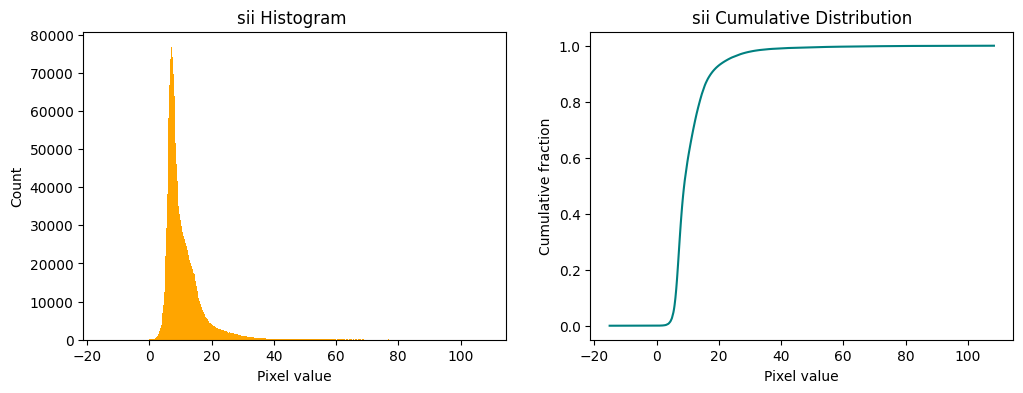

In [10]:
plot_hist(fits_sii,'sii')

### SII Analysis
**Histogram**:
* Sharp peak near 0, rapid drop-off.

* Skewed left — very faint signal.

**CDF**:
* Steep rise up to 40, then flattens.

* Most pixels are below 30–40.

**Inference**:
* Very faint channel, easily drowned out.

* Needs strong stretch and boost to show up in RGB.

**Recommendation**:
* Percentile cut: 1–99% → [~0, ~40]

* Stretch: asinh with beta ≈ 1.0

* Boost: Multiply by ~1.7, gamma ≈ 1.2

*But stretching is a nonlinear transformation, but normalization comes first to ensure all channels are on a comparable scale before we apply any nonlinear tweaks.*

**What Normalization Does**
1. Mask zeros-Removes mosaic blanks or invalid pixels.

2. Clip outliers-Uses percentile (e.g., 1–99%) or z-score to trim extreme values.

3. Rescale-Maps remaining values linearly to the [0, 1] range.

In [11]:
import numpy as np

def normalize_channel(data, lo_percentile=1, hi_percentile=99, mask_zeros=True, zscore_clip=False):
    arr = data.copy()
    
    # Step 1: Build a mask for valid pixels
    if mask_zeros:
        mask = arr != 0
        valid = arr[mask]   # 1D array of valid pixels for stats
    else:
        valid = arr.flatten()
    
    # Step 2: Clip outliers
    if zscore_clip:
        mean, std = valid.mean(), valid.std()
        lo, hi = mean - 3*std, mean + 3*std
    else:
        lo, hi = np.percentile(valid, [lo_percentile, hi_percentile])
    
    # Step 3: Clip but keep 2D shape
    arr = np.clip(arr, lo, hi)
    
    # Step 4: Rescale to [0, 1]
    norm = (arr - lo) / (hi - lo + 1e-9)
    return norm


# Since for all fits file the distribution as observed from the histogram graph is not gaussian - hence we would keep the zscore method set to false...
# and work with the percentile method for skewed data

In [12]:
norm_oiii = normalize_channel(fits_oiii, lo_percentile=1, hi_percentile=99)
norm_ha   = normalize_channel(fits_ha,   lo_percentile=1, hi_percentile=99)
norm_sii  = normalize_channel(fits_sii,  lo_percentile=1, hi_percentile=99)

*Normalization puts all channels on a fair scale (0–1), removing bias from raw brightness.*

Stretching then applies a nonlinear transformation to:

* Compress bright stars

* Expand faint gas clouds

* Reveal hidden gradients

In [13]:
from astropy.visualization import AsinhStretch, LogStretch, SqrtStretch, ImageNormalize

def stretch_channel(data, mode="asinh", beta=0.8):
    if mode == "asinh":
        stretch = AsinhStretch(beta)
    elif mode == "log":
        stretch = LogStretch()
    elif mode == "sqrt":
        stretch = SqrtStretch()
    else:
        stretch = lambda x: x  # identity fallback
    
    norm = ImageNormalize(data, stretch=stretch)
    return norm(data)

In [14]:
s_ha   = stretch_channel(norm_ha,   mode="sqrt")  # strong signal, gentle stretch
s_oiii = stretch_channel(norm_oiii, mode="asinh", beta=0.9)
s_sii  = stretch_channel(norm_sii,  mode="asinh", beta=1.0)

In [15]:
def gamma_boost(data, gamma=1.1, weight=1.0):
    return np.power(np.clip(data * weight, 0, 1), gamma)

r = gamma_boost(s_sii,  gamma=1.2, weight=1.7)
g = gamma_boost(s_ha,   gamma=1.0, weight=1.0)
b = gamma_boost(s_oiii, gamma=1.15, weight=1.4)

rgb = np.dstack([r, g, b])

### Luminance Time ;)

We’ll apply:

**CLAHE** (Contrast Limited Adaptive Histogram Equalization)

* Boosts local contrast without blowing out stars

**Richardson-Lucy Deconvolution**

* Simulates super-resolution by sharpening edges

In [16]:
# We consider the G or ha channel as the Luminance layer as it's the strongest layer

from skimage import exposure
from skimage.restoration import richardson_lucy
import numpy as np

def enhance_luminance(channel, clip_limit=0.03, psf_size=3, iterations=15):
    """
    Enhance a luminance channel using CLAHE and Richardson-Lucy deconvolution.
    
    Parameters:
    -----------
    channel : 2D numpy array
        Normalized and stretched grayscale channel (e.g., Ha).
    clip_limit : float
        CLAHE contrast limit (default 0.03).
    psf_size : int
        Size of the point spread function kernel (default 3).
    iterations : int
        Number of Richardson-Lucy iterations (default 15).
    
    Returns:
    --------
    L_sharp : 2D numpy array
        Enhanced luminance channel.
    """
    # Step 1: Local contrast enhancement (CLAHE)
    L = exposure.equalize_adapthist(channel, clip_limit=clip_limit)
    
    # Step 2: Richardson-Lucy sharpening
    psf = np.ones((psf_size, psf_size), dtype=np.float32) / (psf_size**2)
    L_sharp = richardson_lucy(L, psf, num_iter=iterations)
    
    return L_sharp


In [17]:
# Apply to Hα channel (best choice for luminance)
L_sharp = enhance_luminance(s_ha)

# Apply luminance to RGB composite
rgb_lum = np.clip(rgb * (L_sharp[..., None] + 1e-3), 0, 1)

### 🔬 What is a PSF?

**PSF = Point Spread Function**

It describes how a perfect point source (like a star) appears in your image after passing through optics + atmosphere + detector.

Ideally, a star should be a single pixel. In reality, it’s blurred into a small disk with wings.

The PSF is usually modeled as a small kernel (e.g., 3×3 or Gaussian) that represents this blur.

In deconvolution, the PSF is the “blurring fingerprint” we try to undo.

---

### How Richardson–Lucy Works
**Richardson–Lucy is an iterative deconvolution algorithm**. Here’s the intuition:

Model the image formation

Observed image = True image ⊗ PSF (convolution) + noise

⊗ means convolution.

Start with a guess

Begin with an initial estimate of the true image (often uniform or the observed image itself).

Iterative update

At each step, compare the observed image with the blurred estimate.

Correct the estimate by multiplying with the ratio:

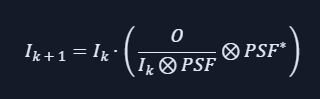

𝑂
 = observed image

𝐼
𝑘
 = current estimate

𝑃
𝑆
𝐹
∗
 = flipped PSF (adjoint)

Converge to sharper image

After ~10–30 iterations, stars become tighter, edges crisper, and fine detail emerges.

Too many iterations → noise amplification (ringing).

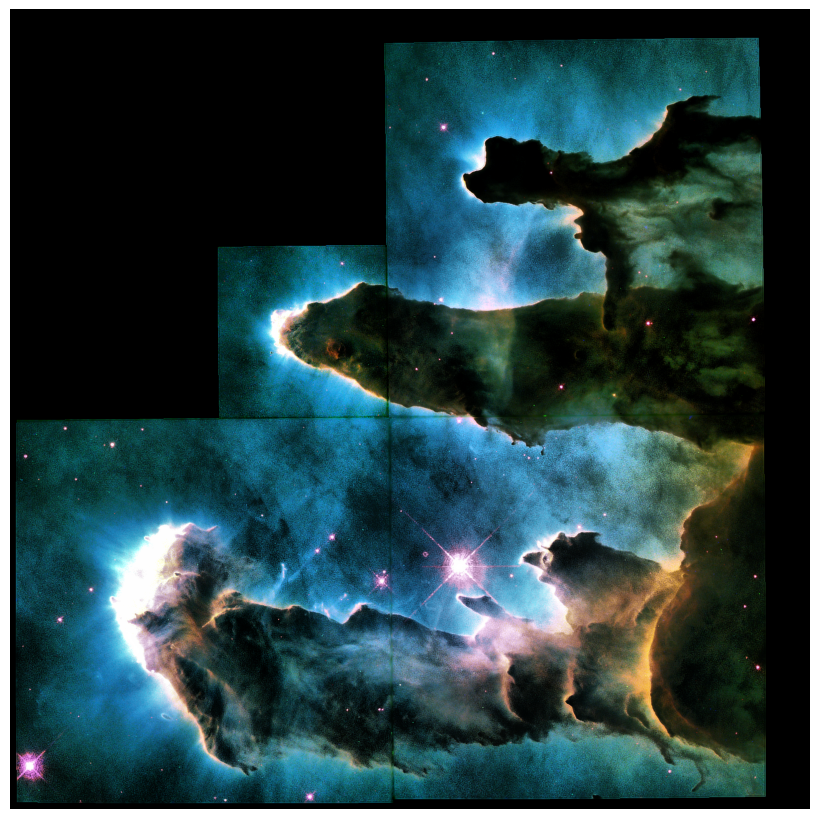

In [18]:
import matplotlib.pyplot as plt

# Create a wide (horizontal) figure
plt.figure(figsize=(16,8))   # width=16, height=8 → horizontal aspect
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Show the image
plt.imshow(rgb_lum)

# Remove grid and axes for clean display
plt.axis('off')

plt.imshow(rgb_lum, origin='lower')   # flips orientation if needed

# Show the result
plt.show()


### **Not Just to see - to feel it - A step ahead - a leap beyond into the Cosmos**

welcome to the auditory section :)

**Sonification**

* Brightness → loudness

* Vertical position → pitch

* Color channel (SII, Hα, OIII) → instrument or waveform

---

**SII (faint, low signal) → Bass drone**

* Map brightness → low frequencies (100–400 Hz)

* Gives a deep foundation

**Hα (strong, dominant signal) → Midrange melody**

* Map brightness → sine wave sweep (400–1200 Hz)

* Carries the main “voice”

**OIII (medium, highlights) → High shimmering tones**

* Map brightness → arpeggiated high frequencies (1200–3000 Hz)

*  Adds sparkle and detail

In [49]:
import numpy as np
import sounddevice as sd
from scipy.signal import butter, lfilter, fftconvolve

def bandpass_noise(lowcut, highcut, sr, n_samples):
    noise = np.random.normal(0, 1, n_samples)
    b, a = butter(4, [lowcut/(sr/2), highcut/(sr/2)], btype='band')
    return lfilter(b, a, noise)

def apply_reverb(signal, sr=44100, decay=0.4):
    impulse = np.exp(-np.linspace(0, 3, int(sr*0.5)) * decay)
    impulse /= np.max(impulse)
    return fftconvolve(signal, impulse, mode='full')[:len(signal)]

def sonify_pillars_sweep(sii, ha, oiii,
                         samplerate=44100,
                         duration=20.0,
                         play=True):
    """
    Sweeping-tone sonification:
    - Continuous pitch glissando shaped by OIII brightness
    - Wind noise modulated by Hα
    - Bass drones from SII
    """
    def normalize(arr):
        arr = np.squeeze(arr)
        return (arr - arr.min()) / (arr.max() - arr.min() + 1e-9)

    sii_n, ha_n, oiii_n = normalize(sii), normalize(ha), normalize(oiii)
    H, W = ha_n.shape
    total_samples = int(samplerate * duration)
    t = np.linspace(0, duration, total_samples)

    # --- Bass drone (SII) ---
    bass_level = np.mean(sii_n)
    bass_freq = 60 + bass_level * 40
    bass = np.sin(2*np.pi*bass_freq*t) * 0.2

    # --- Wind noise (Hα) ---
    wind = bandpass_noise(300, 1500, samplerate, total_samples)
    wind_env = np.interp(np.linspace(0, H, total_samples),
                         np.arange(H), np.mean(ha_n, axis=1))
    wind *= wind_env * 0.6

    # --- Sweeping tone (OIII) ---
    oiii_profile = np.mean(oiii_n, axis=1)
    sweep_freq = np.interp(np.linspace(0, H, total_samples),
                           np.arange(H),
                           800 + oiii_profile*2000)
    phase = np.cumsum(sweep_freq) / samplerate
    sweep = np.sin(2*np.pi*phase) * np.interp(np.linspace(0, H, total_samples),
                                              np.arange(H), oiii_profile)

    # --- Blend layers ---
    mono = bass + wind + sweep

    # Stereo drift
    pan = 0.5 + 0.5*np.sin(2*np.pi*0.01*t)
    left = np.cos(pan*np.pi/2)
    right= np.sin(pan*np.pi/2)
    audio = np.vstack([mono*left, mono*right]).T

    # Normalize & reverb
    audio /= np.max(np.abs(audio)+1e-9)
    audio[:,0] = apply_reverb(audio[:,0], samplerate)
    audio[:,1] = apply_reverb(audio[:,1], samplerate)
    audio /= np.max(np.abs(audio)+1e-9)

    if play:
        sd.play(audio, samplerate)
        sd.wait()

    return audio


In [50]:
sonify_pillars_sweep(s_sii,s_ha,s_oiii)

array([[-8.07236388e-17, -1.93736733e-16],
       [ 4.42463266e-05,  4.42464256e-05],
       [ 1.32732592e-04,  1.32733087e-04],
       ...,
       [ 1.62552000e-02,  4.06951213e-01],
       [ 1.61152743e-02,  4.02920498e-01],
       [ 1.59739378e-02,  3.98854443e-01]], shape=(882000, 2))